# О проекте

Цель проекта - создать рекомендательную систему для сети аптек, чтобы во время покупки зарегестрированному пользователю предлагались товары, которые он будет склонен докупить во время визита в аптеку.

Ячейки кода выполняются **только последовательно**, для получения исключительно результатов моделей заголовок EDA можно пропустить. Время на выполнение ноутбука $\approx 55min$ на AMD Ryzen 5 2600 Six-Core Processor 3.40 GHz

# DISCLAIMER

Максимизация прибыли и способ дать клиенту то, что он хочет это в целом здорово, но не в области здравохранения.
Хорошая рекомендательная система для аптек должна включать логику, по которой пользователям не будут предлагаться неэффективные препараты, гомеопатия или же наоборот препараты по рецепту или с сильными побочными эффектами при наличии лучших аналогов. Назначение того или иного лекарства должно быть обоснованно врачом, а рекомендация должна работать скорее на базовых лекарствах, медицинском инвентаре, витаминах и эффективных БАДах.  

# import 

**Python 3.11.1**

```pip
fasttext==0.9.2 gensim==4.3.1 scikit-learn==1.2.0 matplotlib==3.6.2 pandas==1.5.2 scipy==1.10.0
```

In [3]:
import pickle 
import pandas as pd
import re
from joblib import Parallel, delayed

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle

import scipy as sp
import numpy as np
import math
from matplotlib import pyplot as plt


import fasttext
from gensim.utils import simple_preprocess

# functions

In [4]:
### preprocessing ###

"""extract data from product table"""
def extract_columns(ser):
    first_num_pat = re.compile('\(\d+\)')
    second_num_pat =re.compile('(-\d+)$|(\d+)$')

    err = [] 
    err_idx = []  
    product_idx = [] 

    lst = []
    list_of_lists = []
    for i in ser.index : 

        s = ser[i]
        lst = []

        first_num_search = first_num_pat.search(s)
        second_num_search = second_num_pat.search(s)

        try:
            name_search = s[ first_num_search.span()[1]
                             : second_num_search.span()[0] ]

            lst.append(first_num_search[0][1:-1])
            lst.append(second_num_search[0])
            lst.append(name_search[1:-1])

            list_of_lists.append(lst)
            product_idx.append(i)

        except: 
            err.append(s)
            err_idx.append(i)


    df = pd.DataFrame(list_of_lists,
                      columns=["mystery", "subcategory", "name"],
                      index=product_idx)

    df = df.astype({'mystery': 'int64',
               "subcategory": "int32",
              "name": "string"})

    return df, pd.Series(err, index=err_idx)

"""remove "(12341234) " like thing in string"""
def get_name(s):
    first_num_pat = re.compile('\(\d+\)')
    return s[first_num_pat.search(s).span()[1] + 1:]


"""Turn set into train and test set"""
# [1,2,3,4,5] -> [[1,2,3], [4,5]] etc. Proportion: 2/1
def train_test_validation(series_of_lists):
    list_of_lists_of_list = []
    for original_list in series_of_lists:


        # Define the split list with desired lengths
        l = len(original_list)
        train = int(l*2/3)
        test = l - train

        split_list = [train,test]

        # Initialize an empty list to store the resultant split list
        resultant_split_list = []

        # Initialize a variable to keep track of the starting index of each slice in the original list
        start_index = 0

        # Iterate over the split list
        for length in split_list:
            # Take a slice of the original list starting from the start_index and ending at start_index + length
            slice_list = original_list[start_index:start_index+length]
            # Append the slice to the resultant split list
            resultant_split_list.append(slice_list)
            # Update the start_index to point to the start of the next slice
            start_index += length

        #print the resultant split list
        list_of_lists_of_list.append(resultant_split_list)
    
    return pd.DataFrame(list_of_lists_of_list,
                        columns=["train", "test"],
                        index=series_of_lists.index)


"""split list into n chunks"""
def chunker(lst, n_chunks=12):
    lists_of_lists = []
    n_chunks = 12

    shard = len(lst)//n_chunks
    counter = 0 
    last_item = shard
    for i in range(n_chunks):
        if i == n_chunks-1:
            lists_of_lists.append(lst[counter:])
        else:
            lists_of_lists.append(lst[counter:last_item])
            counter += shard
            last_item += shard
        
    return lists_of_lists


def get_conctact_goods_list(contact_ids):
    contacts_goods_list = []

    for i in contact_ids:
        lst = []
        for j in day_distinct_cheks.loc[i].product_id:
            lst += j
        contacts_goods_list.append(lst)
    
    return contacts_goods_list




"""drop duplicates from a list, while preserving order"""
def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

'''get only name of the product'''
num_pattern = re.compile('\d')
def num_cutter(s):
    try: return s[:num_pattern.search(s).span()[0]]
    except: return s


### models ###

"""My recommendation collaborative user based algorithm"""
def get_recs(lst, similar_row_top_n=20, recomendations_n=100):

    recs = []

    for i in lst:

        current_row_nonzero_columns_idx = df_csr[i,:].indices
        p1 = sp.sparse.csr_matrix(df_csc[:, current_row_nonzero_columns_idx])

        nonzero_idx = np.unique(p1.nonzero()[0])
        nonzero_M = df_csr[nonzero_idx,]

        # This costs a lot
        top_n_idx = pd.Series(
        np.sum(nonzero_M[:,current_row_nonzero_columns_idx].A.T,
               axis=0)).sort_values(ascending=False).iloc[:similar_row_top_n].index

        vector_sums = nonzero_M[top_n_idx,].sum(axis=0).A1

        recomendations = pd.Series(np.delete(vector_sums,
                                             current_row_nonzero_columns_idx),
                                   index=np.delete(mlb.classes_,
            current_row_nonzero_columns_idx)).sort_values(ascending=False)

        recs.append(recomendations.index[:recomendations_n])
    return recs



"""Need for getting names of the product by id or generate w2v arrays"""
def transform_array(transform_stuff, array):

    list_of_lists = [] # to func!
    for lst in array:
        list_of_items = []
        for item in lst:
            list_of_items.append(transform_stuff[item])
        list_of_lists.append(list_of_items)
    return list_of_lists

"""Model for generating 2 stage recomendations with w2v and collab. method"""
def get_2stage_w2v_collab_recs(lst_of_indexes):
    recs = []
    for i in lst_of_indexes:
        neigh_index = (neigh_checks.kneighbors(
                                 [w2v_cheks_test_arrays[i]],
                                 15000, return_distance=False)[0])


        need = df_csr[neigh_index,:]
        need_index = np.unique(need.indices)
        non_sparse_index = mlb.classes_[need_index]
        
        row = np.sum(need[:, need_index].A,axis=0)
        recs.append( list(pd.Series(row, index=non_sparse_index).sort_values(
             ascending=False).index[:100]) )

    return recs

'''Model to generate w2v recomendations by product subsequence in checks '''
def get_w2v_check_recs(lst_of_indexes):
    recs = []
    for i in lst_of_indexes: 

        arr = []
        for i, nebur in enumerate(neigh_checks.kneighbors([w2v_cheks_test_arrays[i]],
                                 100000, return_distance=False)[0]):
            arr += [x for x in X_train.iloc[nebur] 
                    if x not in X_test.iloc[i]
                    if x not in arr]
            if len(arr) >= 100:

                break
        recs.append(arr[:100])
    return recs


'''get metrics of the recomendations'''
def get_validation(recs, y_test):
    validation = []
    for num in range(len(recs)):
        rec_idx = []
        for i, rec in enumerate(recs[num]):
            if rec in y_test.iloc[num]: rec_idx.append(i)
        validation.append(rec_idx)
        
    success_recs_count = pd.Series(validation).apply(len)
    
    rank_distribution = []
    for i in validation: rank_distribution += i
    rank_distribution = pd.Series(rank_distribution)
    
    count_division = success_recs_count/\
                     y_test.apply(len).reset_index(drop=True)
    
    return validation, success_recs_count, rank_distribution, count_division

# data

In [5]:
with open("Product_dict.pkl","rb") as f:
    product_dict = pickle.load(f)
product_df = pd.DataFrame(product_dict,index=["info"]).T

checks = pd.read_csv('checks.csv', low_memory=False)

# copy for independency of the EDA and preprocessing
product_df_copy = product_df
checks_copy     = checks

# EDA 

Важно заметить, что разведывательный анализ данных динамический - то есть с последовательной предобработкой. Это позволяет сразу удалять неподходящие для столбца строки и не тратить на них время в других колонках. 

In [6]:
with open("Product_dict.pkl","rb") as f:
    product_dict = pickle.load(f)
product_df = pd.DataFrame(product_dict,index=["info"]).T

checks = pd.read_csv('checks.csv')

C:\Users\zetet\AppData\Local\Temp\ipykernel_14804\9801815.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  checks = pd.read_csv('checks.csv')


## product_id связывает две таблицы

In [7]:
display(checks.iloc[1])
checks.iloc[1]["name"]

sale_date_date                                                    2018-12-07
contact_id                                                            198287
shop_id                                                                279.0
product_id                                                          134832.0
name                       (62448) Перекись водорода р-р наружн. 3% фл.по...
product_sub_category_id                                                404.0
product_category_id                                                     93.0
brand_id                                                                -1.0
quantity                                                                1,00
Name: 1, dtype: object

'(62448) Перекись водорода р-р наружн. 3% фл.полимерн. 100мл'

## product_df

In [8]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30418 entries, 168308 to 192468
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   info    30418 non-null  object
dtypes: object(1)
memory usage: 475.3+ KB


На первый взляд нет пропусков

In [9]:
product_df["info"].value_counts()[:3]

N/A -1                                                 260
(42390) Леденцы с экстрактом эхинацеи пак 50г №1 -1      1
(34011) Календулы настойка жидк фл 40мл N1 613           1
Name: info, dtype: int64

На второй взгляд есть пропуски, их следует удалить, поскольку их невозможно заполнить

Посмотрим на структуру строк

In [10]:
for i in range(3): print(product_df["info"][i])
print("\nс индексами:\n",product_df["info"][:3])

(197312) Пакет-майка 25см х 45см 906
(62448) Перекись водорода р-р наружн. 3% фл.полимерн. 100мл 404
(72183) Салициловая кислота р-р спирт 2% фл 40мл N1 404

с индексами:
 168308                 (197312) Пакет-майка 25см х 45см 906
134832    (62448) Перекись водорода р-р наружн. 3% фл.по...
101384    (72183) Салициловая кислота р-р спирт 2% фл 40...
Name: info, dtype: object


**Есть числа вначале и в конце**
- Число в конце - подкатегория товара. Ею можно заполнить пропуски подкатегорий в чеках.
- Число в начале - что-то мистическое, что нельзя определить по имеющимся столбцам в чеках. Можно предположить, что это количество товара на складе.

**Атомизируем ячейки таблицы**

In [11]:
product_df, err = extract_columns(product_df["info"])

Возможно некоторых подкатегорий(0,1) нет в продуктовом каталоге, но есть в чеках. Нет - всё норм.

Но часть чеков с категорией -1 не являются неопозноваемыми, их категория есть в каталоге.

In [12]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29722 entries, 168308 to 192468
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   mystery      29722 non-null  int64 
 1   subcategory  29722 non-null  int32 
 2   name         29722 non-null  string
dtypes: int32(1), int64(1), string(1)
memory usage: 812.7+ KB


Часть строк отсеялось в связи с ошибками при получении колонок из строк.

In [13]:
err.sample(10)

170438                                               N/A -1
178567                                               N/A -1
198929    (443242e3-3650-11e7-8157-00155d5ea771) Ободков...
195667      (0034dc95-5bf2-11e7-815c-00155d01e612) BOSS 865
203869    (142a63d5-5bf4-11e7-815c-00155d01e612) Marc Ja...
180382                                               N/A -1
222381        (0000123186 ) Коробка шляпная микс 11*11см -1
212546    (6852ad62-83e2-11e7-8168-00155d01e12c) SV 1.5 ...
204023    (c9d97f34-3ece-11e7-8159-00155d01e6f9) MAXIMA ...
211111    (9d443cd6-b985-11e7-8aa6-00155d084300) STARCK 865
dtype: object

Ошибки содержат пропуски, разного рода медицинские анализы, виды растений, частей оптики и прочих не относящихся к аптеке вещей. Их обязательно нужно исключить

In [14]:
print("В подкатегориях есть пропуски и их:",len(product_df[product_df.subcategory==-1]))

В подкатегориях есть пропуски и их: 5099


Однако не во всех пропусках подкатегории нет данных:

In [15]:
product_df[product_df.subcategory==-1].iloc[0]

mystery                                                    66684
subcategory                                                   -1
name           Пакет майка "Благодарим за покупку" (28+14) х ...
Name: 94270, dtype: object

Но все же есть пропуски без полезной информации

In [16]:
product_df[(product_df.subcategory==-1) & (product_df.name == "название")]

,mystery,subcategory,name
349434,260236,-1,название
213597,110031974,-1,название
213576,110031973,-1,название
192519,110041248,-1,название
192817,110048361,-1,название
...,...,...,...
193603,110044169,-1,название
193484,110050486,-1,название
192459,110020427,-1,название
193510,110047818,-1,название


Исключим их

In [17]:
product_df = product_df.drop(
    product_df[(product_df.subcategory==-1) 
               & (product_df.name == "название")].index, axis="rows")

In [18]:
product_df.mystery.sort_values()

97855               4
131614              5
63525              10
121939             11
41256              19
             ...     
218623    20016679418
220577    20016679434
220278    20016679510
219634    20016679644
221842    20016679658
Name: mystery, Length: 29164, dtype: int64

In [19]:
product_df.mystery.sample()

156344    123832
Name: mystery, dtype: int64

mystery не является общим числом продаж

In [20]:
checks.groupby("product_id").sale_date_date.count().sort_values()

product_id
363586.0         1
233397.0         1
214916.0         1
120091.0         1
214914.0         1
             ...  
137539.0     77153
110629.0     87792
158662.0     89851
168308.0    118106
129195.0    169191
Name: sale_date_date, Length: 36549, dtype: int64

In [21]:
checks.groupby("product_sub_category_id").product_id.count().sort_values()

product_sub_category_id
 939.0          1
 587.0          1
 630.0          1
 660.0          1
 704.0          1
           ...   
 404.0     588604
-1.0       652908
 595.0     749197
 397.0     841103
 738.0    2555316
Name: product_id, Length: 440, dtype: int64

In [22]:
product_df.mystery.value_counts()

1251     2
15514    2
15615    2
24796    2
15533    2
        ..
28136    1
57707    1
79611    1
55810    1
94866    1
Name: mystery, Length: 29148, dtype: int64

**И не является количеством продаж по подкатегориям**

Оставим гипотезу, что mystery - остаток товара на складе и оставим это число в покое.

[Сверив](#product_sub_category_id) колонки подкатегорий среди чеков оказалось, что после фильтрации чеков по каталогу, единственная полезная информация в каталоге - наименование товара

In [23]:
product_df.index = product_df.index.astype("int32")

##  checks

In [24]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000003 entries, 0 to 20000002
Data columns (total 9 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   sale_date_date           object 
 1   contact_id               object 
 2   shop_id                  float64
 3   product_id               float64
 4   name                     object 
 5   product_sub_category_id  float64
 6   product_category_id      float64
 7   brand_id                 float64
 8   quantity                 object 
dtypes: float64(5), object(4)
memory usage: 1.3+ GB


Приведём столбцы к праильным типам

In [25]:
checks.sample(3)

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
15752818,2018-05-01,1500928,1468.0,95371.0,(76176) Панкреатин таб.п.о.кишечнораств. 25 ЕД...,601.0,135.0,-1.0,"2,00"
10189749,2018-03-16,1961670,1884.0,109395.0,(2859) Сыр плавленый Сыроварни Орлова с травам...,-1.0,-1.0,882.0,"1,00"
3663542,2018-11-14,395460,601.0,24785.0,(63753) Чудо Хаш гель-бальзам для тела 70г,648.0,148.0,-1.0,"1,00"


Правильные типы для столбцов:
- `sale_date_date` - datetime
- `contact_id` - int32
- `shop_id` - int32
- `name` - string
- `product_sub_category_id` - int32
- `product_category_id` - int32
- `brand_id` - int32
- `quantity` - int32

### product_id

 

Прежде всего нужно убрать из чеков товары, которых нет в каталоге. Это позволит не нарушать бизнес требование и рекомендовать только доступные товары.

In [26]:
#preprocessing
checks_without_product = checks.product_id.dropna()[
    ~checks.product_id.dropna().isin(
        product_df.index.astype("float64"))]

print(len(checks_without_product),"- СТОЛЬКО ПРОДАННЫХ ТОВАРОВ НЕТ В КАТАЛОГЕ")

176831 - СТОЛЬКО ПРОДАННЫХ ТОВАРОВ НЕТ В КАТАЛОГЕ


Их следует исключить

In [27]:
#preprocessing
checks = checks[~checks.index.isin(checks_without_product.index)]

In [28]:
print(len(checks) - len(checks.dropna()), "- количество очевидных пропусков")

3 - количество очевидных пропусков


поскольку очевидных пропусков почти нет, их следует сразу исключить из датасета

In [29]:
checks = checks.dropna()

Теперь можно привести колонку к правильному типу

In [30]:
checks.product_id = checks.product_id.astype("int32")

### sale_date_date

Показать в теченнии какого периода собраны чеки

In [31]:
checks.sale_date_date[0]

'2018-12-07'

Столбец представляет из себя дату покупки товара, переведём его в правильный тип

In [32]:
checks.sale_date_date = pd.to_datetime(checks.sale_date_date, errors="coerce")

In [33]:
print("В столбце всего",
      len(checks.sale_date_date) - len(checks.sale_date_date.dropna()),
      "пропусков")

В столбце всего 0 пропусков


Из столбца можно сформировать временной ряд.

In [34]:
checks.sale_date_date.sort_values()

4801700   2018-01-01
6670539   2018-01-01
6670540   2018-01-01
6670541   2018-01-01
6670542   2018-01-01
             ...    
115219    2018-12-09
115218    2018-12-09
115217    2018-12-09
115329    2018-12-09
115273    2018-12-09
Name: sale_date_date, Length: 19823169, dtype: datetime64[ns]

В датасете представленны данные за почти 1 год продаж 

### product_sub_category_id

Является подкатегорией товара и дублируется в `product_df.subcategory`

In [35]:
checks.product_sub_category_id.iloc[:3]

0    906.0
1    404.0
2    404.0
Name: product_sub_category_id, dtype: float64

In [36]:
print("В столбце всего",
      len(checks.product_sub_category_id)
      - len(checks.product_sub_category_id.dropna()),
      "очевидных пропусков")

В столбце всего 0 очевидных пропусков


In [37]:
print(checks.product_sub_category_id.value_counts()[-1.0],
     "товаров в чеках без указанной категории")

486629 товаров в чеках без указанной категории


Есть подкатегория -1. И в ней лежит действительно много товаров.

Проверим, соотносится ли количество уникальных товаров без категории в чеках и в каталоге

In [38]:
product_sub_len = (product_df.subcategory == -1).value_counts()[True]

print(product_sub_len,
     " - в каталоге у стольки уникальных товаров не указана подкатегория")

4541  - в каталоге у стольки уникальных товаров не указана подкатегория


Для этого нужно посчитать все уникальные product_id в чеках с подкатегорией -1.0

In [39]:
check_sub_len = checks[checks.product_sub_category_id==-1].product_id.nunique()

print(check_sub_len,
     "- в чеках у стольки уникальных товаров не указана подкатегория")

4541 - в чеках у стольки уникальных товаров не указана подкатегория


Может быть чеки невозоможно дополнить информацией из каталога

In [40]:
checks[checks.product_sub_category_id.isin(
    product_df[product_df.subcategory == -1].index.astype("float64"))]

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity


И это так! Получается, что единственная полезная информация из каталога после предобработки - описание товаров. И то, она дублируется в чеках, но зато её не нужно агрегировать - она готова для модели.

### contact_id

id контакта. Можно сказать, что это идентификатор пользователя.

In [41]:
checks.contact_id.sample(3)

4341428     1972776
15473341    1169545
15133480    2609491
Name: contact_id, dtype: object

In [42]:
checks.contact_id.info()

<class 'pandas.core.series.Series'>
Int64Index: 19823169 entries, 0 to 19999999
Series name: contact_id
Non-Null Count     Dtype 
--------------     ----- 
19823169 non-null  object
dtypes: object(1)
memory usage: 302.5+ MB


Стоит поменять тип данных

In [43]:
checks.contact_id = checks.contact_id.astype("int64")

Посмотрим количестово покупок за дни у контакта 2418385, дабы убедиться в том, что контакт очень похож на зарегестрированного покупателя аптеки.

In [44]:
checks[checks.contact_id==2418385].groupby("sale_date_date").count().product_id

sale_date_date
2018-05-30    7
2018-06-08    2
2018-11-21    3
2018-11-30    6
2018-12-07    5
Name: product_id, dtype: int64

К слову это единственная информация о пользователе, поэтому не стоит делать user-item рекомендации, ведь нельзя по случайному номеру предугадать вкусы человека на покупку.

Однако если человек уже совершал покупку, то вероятно, что он может купить что-то из того, что он уже покупал или товары похожие на его предыдущие покупки.

### name
Представляет из себя строку, содержащуюю наименование товара с мистическим числом в начале. Колонка содержит часть информации из каталога

In [45]:
checks.name[1232]

'(49151) Маалокс сусп.д/приема внутрь пак.15мл №30'

Приведем содержимое колонки к правильному типу

In [46]:
checks.name = checks.name.astype("string")

Взглянем на распределение, может быть, есть пропуски или другие аномалии

In [47]:
checks.name.value_counts()[:10]

(48791) Свободная сумма НДС18% (служебный)           169191
(197312) Пакет-майка 25см х 45см                     118106
(181542) Карта Забота о Здоровье                      89851
(57733) Корвалол капли д/приема внутрь 25мл           87792
(117825) Панангин таб.п.п.о.№50                       77153
(81509) PL Хлоргексидин биглюконат р-р 0.05% ф...     73543
(20116) Тауфон капли глазн 4% фл 10 мл. пласт....     69044
(70458) Пенталгин таб.п.п.о.№24 (без кодеина)         68622
(118125) Кардиомагнил таб.п.п.о.75мг №100             67034
(180739) Омепразол-Акрихин капс.кишечнораст.20...     66781
Name: name, dtype: Int64

**Подозрительно**
- Карта Забота о Здоровье
- Свободная сумма НДС18% (служебный)

**Свободная сумма НДС18% (служебный)**

In [48]:
checks[checks.name == "(48791) Свободная сумма НДС18% (служебный)"][:3]

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
4776837,2018-01-05,1393270,1505.0,129195,(48791) Свободная сумма НДС18% (служебный),-1.0,-1.0,-1.0,"1,00"
4776838,2018-01-05,1789248,1522.0,129195,(48791) Свободная сумма НДС18% (служебный),-1.0,-1.0,-1.0,"1,00"
4776839,2018-01-05,1574740,1524.0,129195,(48791) Свободная сумма НДС18% (служебный),-1.0,-1.0,-1.0,"1,00"


In [49]:
checks[checks.product_id == 129195].name.value_counts()

(48791) Свободная сумма НДС18% (служебный)    169191
Name: name, dtype: Int64

In [50]:
product_df.loc[129195]

mystery                                     48791
subcategory                                    -1
name           Свободная сумма НДС18% (служебный)
Name: 129195, dtype: object

Видимо это часть из чека, которая имеется в каталоге как товар. И служит она для внутриаптечных операций или печаталась в чеке вместе с остальными товарами. Для нас это пустое значение, нужно удалить его из обоих таблиц

In [51]:
# preprocessing
product_df.drop(129195,axis="rows", inplace=True)
checks.drop(checks[checks.product_id== 129195].index, axis="rows",inplace=True)

**Карта Забота о Здоровье**

In [52]:
checks[checks.name == "(181542) Карта Забота о Здоровье"][:2]

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
12,2018-12-07,785614,859.0,158662,(181542) Карта Забота о Здоровье,855.0,194.0,-1.0,"1,00"
48658,2018-12-07,970899,868.0,158662,(181542) Карта Забота о Здоровье,855.0,194.0,-1.0,"1,00"


In [53]:
product_df.loc[158662]

mystery                         181542
subcategory                        855
name           Карта Забота о Здоровье
Name: 158662, dtype: object

Карта Забота о Здоровье есть в каталоге и в чеках. Это должна быть дисконтная карта, у кого-то она есть, у кого-то нет. Логики её получения мы не знаем, поэтому исключим этот товар из датасетов 

In [54]:
# preprocessing
product_df.drop(158662,axis="rows", inplace=True)
checks.drop(checks[checks.product_id== 158662].index, axis="rows",inplace=True)

In [55]:
checks.name[2]

'(72183) Салициловая кислота р-р спирт 2% фл 40мл N1'

#### W2V

При подборе по названию не следует, чтобы поиск велся по количеству таблеток, дозировке, количесвту мг действующего вещества или мл раствора. Ведь странно предлагать парацетомола в таблетках по 200мг, если клиент покупает йод с дозировкой в 200мкг.

Уберём цифры из первой строчки

In [56]:
s = product_df.name.iloc[0]
print(s)
first_num_pat = re.compile('\d')

Пакет-майка 25см х 45см


In [57]:
product_df["name_wsout_num"] = product_df.name.apply(num_cutter)

In [58]:
checks["name_wsout_num"] = checks.name.apply(num_cutter)

### brand_id

In [59]:
checks.brand_id.value_counts().iloc[:4]

-1.0       15745915
 1520.0      881064
 1348.0      151282
 2038.0      105401
Name: brand_id, dtype: int64

16 миллионов пропусков. это больше 75% от общего количества строк. Этот столбец не будет учитываться моделью

### quantity
Количество купленного наименования в чеке

In [60]:
checks.quantity.sample()

3421647    1,00
Name: quantity, dtype: object

In [61]:
print("Распространённость повторной покупки одного товара в чеке","\n\n", 
      checks.quantity.value_counts()[:7])

Распространённость повторной покупки одного товара в чеке 

 1,00     16370780
2,00      1850335
3,00       418531
5,00       204142
4,00       162662
10,00      150183
0,20        48294
Name: quantity, dtype: int64


Поскольку некультурно предлагать клиенту купить товар в количестве более одной штуки, то этот столбец не будет участвовать в моделировании. Важно заметить только то, что что любая покупка товара более одного раза не должна быть записана. То есть все повторяющиеся покупки одного товара за один день нужно нивелировать

# data preprocessing

- Возможно стоит добавить подкатегорию и категорию в `product_df`

In [62]:
%%time
product_df = product_df_copy
checks = checks_copy

### product catalog ###########################################################

## extract all columns from catalog
product_df, err = extract_columns(product_df["info"])

## drop missiong values
product_df = product_df.drop(
    product_df[(product_df.subcategory==-1) 
               & (product_df.name == "название")].index, axis="rows")

### checks ####################################################################

## drop checks that are not in the catalog 
checks_without_product = checks.product_id.dropna()[
    ~checks.product_id.dropna().isin(
        product_df.index.astype("float64"))]

checks = checks[~checks.index.isin(checks_without_product.index)]

## drop missing values
checks = checks.dropna()

## set true datatypes ##
# string index to int32
product_df.index = product_df.index.astype("int32")
# sale_date_date to datetime
checks.sale_date_date = pd.to_datetime(checks.sale_date_date, errors="coerce")
# shop_id to int32
checks.shop_id = checks.shop_id.astype("int32")
# product_id to int32
checks.product_id = checks.product_id.astype("int32")
# product_sub_category_id to int32
checks.product_sub_category_id = checks.product_sub_category_id.astype("int32")
# product_category_id to int32
checks.product_category_id = checks.product_category_id.astype("int32")
# contact_id to int32
checks.contact_id = checks.contact_id.astype("int32")
# name to string
checks.name = checks.name.astype("string")

## drop uninteresting columns
checks.drop(["brand_id", "quantity"], axis="columns", inplace=True)

### drop uninteresting rows ###
# drop service goods
product_df.drop(129195,axis="rows", inplace=True)
checks.drop(checks[checks.product_id== 129195].index, axis="rows",inplace=True)

# drop discount cards
product_df.drop(158662,axis="rows", inplace=True)
checks.drop(checks[checks.product_id== 158662].index, axis="rows",inplace=True)

### remove first "(1234) " like  thing in name strings
checks.name = checks.name.apply(get_name)

CPU times: total: 51.7 s
Wall time: 51.7 s


In [63]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19564127 entries, 0 to 19999999
Data columns (total 7 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   sale_date_date           datetime64[ns]
 1   contact_id               int32         
 2   shop_id                  int32         
 3   product_id               int32         
 4   name                     object        
 5   product_sub_category_id  int32         
 6   product_category_id      int32         
dtypes: datetime64[ns](1), int32(5), object(1)
memory usage: 820.9+ MB


# Про валидацию
> **Одна тонкость про валидацию**
>
> Поведение клиента с рекомендациями и без них значительно отличается. Поэтому нельзя наверняка сказать на сколько рекомендации работают лучше на выборке, где рекомендации на практике никогда не вводились. Возможно, с такими рекомендациями пользователь будет чуть чаще покупать привычные ему товары или откроет для себя новые товары, которые ему полюбятся, но это нельзя проверить на выборке, где рекомендаций у клиентов не существует.
>
> Действительную оценку рекомендаций можно проводить, исследуя их на практике, потому-что они влияют на покупки клиентов. Увеличиваются ли продажи с вводом рекомендаций и на сколько? - правильный вопрос для бизнеса. А для исследователя - какое количество **новых** товаров стал покупать клиент аптеки по рекомендациям, на сколько чаще он стал впринципе покупать новые товары и на сколько чаще стали продажи уже знакомых для него товаров. 


**Валидация должна быть сделана с учётом времени. Есть два основных подхода**
- Сравнение рекомендованных и реально купленных товаров на основе каждого чека за день
- Сравнение рекомендованных и реально купленных товаров на основе всех покупок каждого клиента, отсортированных по времени.

Я выбрал второй вариант. Так рекомендации даются иммено клиенту, а не подбираются товары, которые покупаются вместе чаще всего.


Датасет будет сгруппирован по покупателям. Потому-что рекомендации по бизнес логике будут выдаваться конкретному человеку перед кассой. Далее сортируются все покупки каждого клиента по дате и убираются дубли товаров, чтобы не рекомендовать то, что клиент однажды уже покупал. Ведь он скорее всего купит привычные товары сам. Да и результаты модели будут от этого интереснее:)

**Минус подхода - в трейн и тесте могут быть разные уникальные объекты**, а это служит причиной, что часть товаров из каталога просто не будет рекомендоваться до тех пор, пока их не начнут покупать.

---

Важно заметить, что в связи с некоректностью предлогать купить определённый товар несколько раз - любая покупка товара более одного раза не должна быть впринципе быть записана. То есть все товары одного клиента в чеке нужно сделать уникальными

In [64]:
calculation = checks.groupby(["contact_id",
                              "sale_date_date",
                              "product_id"]).count()
calculation.name.value_counts().iloc[:6]

1    18816439
2      344300
3       13939
4        2150
5         639
6         233
Name: name, dtype: int64

Некоторые одинаковые товары были куплены несколько раз в общем чеке за день, исправим это

In [65]:
%%time
# 3 minutes
day_distinct_cheks = checks.groupby(["contact_id",
                                     "sale_date_date"])["product_id"].agg(set)
day_distinct_cheks = day_distinct_cheks.apply(lambda x: list(x))

day_distinct_cheks.iloc[:3]

CPU times: total: 2min 32s
Wall time: 2min 32s


contact_id  sale_date_date
373         2018-02-21        [113441, 147658, 137357, 115823, 91063, 158586...
            2018-11-29                    [57835, 134832, 154101, 19578, 61115]
374         2018-12-07                                                  [38462]
Name: product_id, dtype: object

Мы получили списоки уникальных товаров, каждым пользователем за один раз(за день). Из этих данных уже можно строить Колаборативную фильтрацию. **Привет разреженная матрица**

Упорядочим чеки по клиентам, а затем по времени, чтобы делать проверку на данных из будущего. 

In [66]:
day_distinct_cheks = day_distinct_cheks.reset_index().sort_values(
                        ["contact_id",
                         "sale_date_date"]).set_index(["contact_id",
                                                       "sale_date_date"])

In [67]:
%%time
contact_ids = checks.contact_id.unique()

## ATTENTION! This may eat all of 16gb RAM
# 4 minutes duration...
results = Parallel(n_jobs=4)(delayed(get_conctact_goods_list)(x)
                                  for x in chunker(contact_ids))
contacts_goods_list = []
for i in results:
    for j in i:
        contacts_goods_list.append(j)

CPU times: total: 52.9 s
Wall time: 2min 51s


In [68]:
contacts_goods_list = []
for i in results:
    for j in i:
        contacts_goods_list.append(j)

Невозоможно предсказать следующий купленный товар у клиента аптеки, если покупка была только одна за всё время. Поэтому нужно убрать из датасета клиентов c одной покупкой за всё время. 

Так же стоит исключить дублирующиеся товары, чтобы в предсказаниях просто не подстраивались предыдущие покупки, так можно явнее увидеть пользу от предсказаний. Ибо часто клиент просто повторяет покупки, а задача не определить, какой продукт из уже купленных возьмёт клиент ещё раз, потому что он его так и так купит - для задачи прогнозирования одинаковых покупок лучше подойдут предсказания по временному ряду.

In [69]:
contacts_goods = pd.Series(contacts_goods_list)
contacts_goods.index = contact_ids

# drop duplicates from lists and save order
contacts_goods = contacts_goods.apply(f7) 


При этом важно учитывать, что каждый товар недилим. Разделение на тестовую и тренировочную выборку возомжно, если клиентом было купленно хотя-бы 2 уникальных товара. Округление будет делаться в сторону тестовой выборки.

In [70]:
contacts_goods = contacts_goods[contacts_goods.apply(lambda x: len(x))>1]

Посмотрим на распределение количества купленных товаров у клиентов:

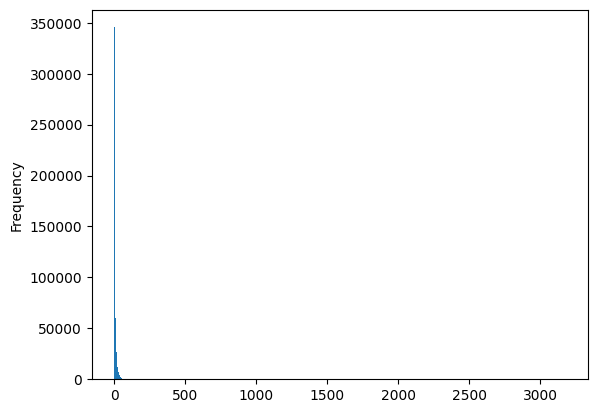

In [71]:
len_goods = contacts_goods.apply(lambda x: len(x))
len_goods.plot.hist(bins=3000);

Ооочень длинный хвост из купленных уникальных товаров, доходящий аж до 3 тысяч наименований. А куплены они всего за год!
Редкий покупатель может похвастаться столь стремительной скупкой аптеки - это компании, занимающиеся перепродажей, частные клиники и лаборатории. Маловероятно, что им нужны рекомендации, а целевая аудитория - не бизнесмены. Поэтому стоит срезать этот хвост

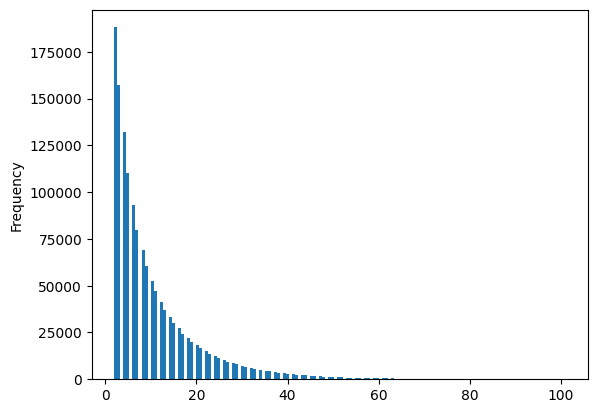

In [72]:
len_goods.sort_values(ascending=True).iloc[:-2500].plot.hist(bins=150);

Воспользуемся интуицией и срежем всех клиентов с покупками более 70 - так распределение будет выглядеть симметричнее и будет с лихвой охвачена целевая аудитория рекомендаций

In [73]:
contacts_goods = contacts_goods[len_goods < 70]

Взглянем на потери:

In [74]:
print(f"{len(contacts_goods_list)} было строк по клиентам\n\
{len(contacts_goods)} стало строк по клиентам\n\
{len(contacts_goods_list)-len(contacts_goods)} - разница")

1639912 было строк по клиентам
1432456 стало строк по клиентам
207456 - разница


Невозвратно ушли две колонки:
- sale_date_date
- shop_id

Остальные же можно подтянуть из каталога

Результаты моделей буду собирать в словарик:

In [75]:
models_results = {}

## Выборки
**Соотношение тренировочного сета к тестовому 2/1** А непосредственно валидация будет происходить  на 10 тысячах строк. Да, технически тут две валидации и обучение будет происходить на 2/3 данных без учёта 10 тысячи строк.

Важно заметить, что некоректно обучать любые модели на информации из фактического будущего для его предсказания, но будущее в датасете определено как тестовые покупки, а прошлое - как тренировочные и в рамках проекта можно пренебречь формальным временем, чтобы не слишком сокращать выборку путём разбиения покупок до определённого числа и покупок после него.

А обучать все модели буду на тренировочном сете просто для того, чтобы их можно было сравнить.

In [76]:
train_test = train_test_validation(contacts_goods)
train_test.sample(5)

,train,test
42645,"[68690, 96723]",[161495]
1891868,"[71276, 107409]","[39954, 104524]"
1684189,"[54592, 65589, 59862]","[90747, 168308]"
842341,"[135427, 98663, 129194, 52106, 53738, 136020, ...","[139502, 95785, 156137, 120443, 51951, 80402, ..."
1293968,"[130113, 94582]","[154019, 60438]"


Перемешаю всю выборку, чтобы избежать неучтенных закономерностей в порядке строк

In [77]:
train_test = shuffle(train_test)

In [78]:
X_test = train_test.train.iloc[:10000]
y_test = train_test.test.iloc[:10000]

X_train = train_test.train.iloc[10000:]

# Неперсонализированные рекомендации

Просто будем рекомендовать каждому клиенту самые популярные товары

In [79]:
goods_byproduct = checks.groupby(["product_id"]).count().name
top100products = goods_byproduct.sort_values(ascending=False).iloc[:100].index

print("Топ 5 товаров:\n")
for i in top100products[:5]:
    print(product_df.name.loc[i])
    
recs = []
for _ in range (10000):
    recs.append(top100products)

Топ 5 товаров:

Пакет-майка 25см х 45см
Корвалол капли д/приема внутрь 25мл
Панангин таб.п.п.о.№50
PL Хлоргексидин биглюконат р-р 0.05% фл.100мл №1 (НДС 18%)
Тауфон капли глазн 4% фл 10 мл. пласт. флак.-кап.


## Результаты 

In [80]:
validation, success_recs_count, rank_distribution, count_division \
    = get_validation(recs,y_test)

Как часто рекомендации совпадают с покупками?

0.4216 - доля совпадения хотя бы одной рекомендациииз всех в покупках клиента


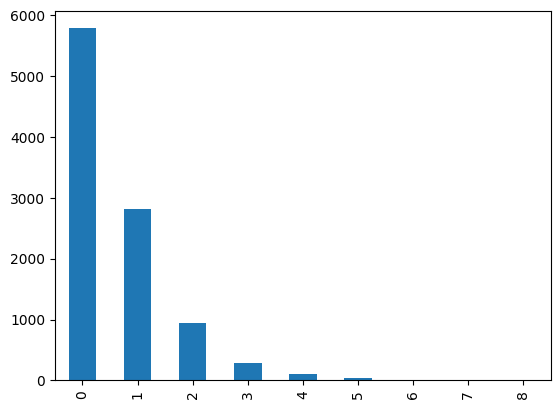

In [81]:
vc = success_recs_count.value_counts()
vc.plot.bar();
succes_proportion = round(1 - vc[0]/len(success_recs_count),4)
print(succes_proportion, "- доля совпадения хотя бы одной рекомендации\
из всех в покупках клиента")

А какого среднее отношение рекомендованных товаров к купленным, если рекомендация всё таки подошла?

In [82]:
succes_count_proportion = round(count_division[count_division != 0].mean(),4)
succes_count_proportion

0.3873

38%! Это много, можно научить регрессор определять вероятность того, что рекомендации подойдут или нет. Поможет повысить метрику и увеличить лояльность клиентов к рекомендациям

Выведем расределение позиции в топе у рекомендаций

32.0 - медиана
38.6042 - среднее


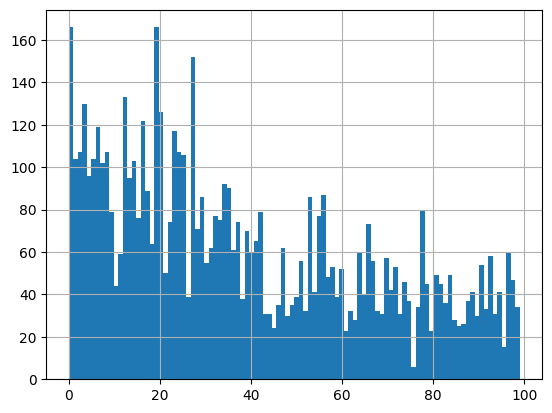

In [83]:
rank_distribution.hist(bins=100);

median = round(rank_distribution.median(),4)
mean = round(rank_distribution.mean(),4)
print(median, "- медиана")
print(mean, "- среднее")

Медиана замыкает первую треть, распределение смещенно к началу рекомендаций, что значит, что они подобраны правильно. Есть интресная деталь в виде сильного расброса значений. Я полагаю, что это связано с тем, что действия покупателей деляться на несколько паттернов, которые можно поделить как минимум на две группы: покупка популярных товаров и покупка всех остальных товаров(Когда клиент лечится от акне или принимает конкретный вид БАДов и т.д.). Популярный товар имеет свойство быть периодически покупаемым большим количеством клиентов и возможно эти колебания отражают этот паттерн для товаров, а белые пропуски - волны остальных товаров.

А какого общее соотношение удачно рекомендованных товаров ко всем покупкам?

In [84]:
all_succes_products_proportion = success_recs_count.sum() / y_test.apply(len).sum()
all_succes_products_proportion

0.16789815011694664

In [85]:
# save model results
models_results["non_personal"] = {
    "succes_proportion" : succes_proportion,
    "succes_count_proportion" : succes_count_proportion,
    "median" : median,
    "mean" : mean,
    "all_succes_products_proportion" : all_succes_products_proportion,
    "rank_distribution" : rank_distribution
}

# Коллаборативная user-based фильтрация  

Должно быть, подобный алгоритм уже существует, но я его назвал "Алгоритм бинарных компенсирующих векторов"

Алгоритм рекомендует наиболее вероятные новые для юзера товары. Специально под специфику выборкок.

**Выборка**:
На примере чеков и последовательных покупок.
Происходит группировка покупок по клиентам, далее по клиентам покупки сортируются по времени от древних до новых и приводятся к уникальному виду таким образом, что при наличии повтора у одного товара после фильтрации по уникальности в ряду останется только самая первая покупка с этим товаром.
Далее создаётся разреженная матрица, где строки - уникальные клиенты, а колонки - уникальные товары. Наличие покупки у клиента это единица, отсутствие - нуль. 
Важно уточнить, что период выборки может быть произвольный и в нём перемешиваются все покупки по времени.

**Алгоритм**:
Рекомендация происходит по отдельному юзеру используя всю выборку. В общем и целом алгоритм сначала подбирает группу похожих на клиента по покупкам юзеров и потом находит среди всех приобритенных ими товаров самые популярные.

1. Выбирается юзер для рекомендации
2. Матрица фильтруется по колонкам, где есть покупки у юзера
3. Индексы непустых значений получившейся матрицы  сохраняются и матрица по ним фильтруется.
4. Разреженная матрица превращается в обычную и в ней ставятся сохранённые индексы разреженной.
5. Находится сумма единиц по строкам обычной матрицы - получается индексированный ряд целых чисел.
6. Ряд сортируется по убыванию
7. Из ряда выбирается фиксированное количество первых индексов с наибольшей суммой, например 30
8. По индексам находятся строки этих 30 клиентов в разреженной матрице и фильтруются колонки, в которых нет значений у всех 30 пользователей. Получившаяся матрица переводится в обычную.
9. Происходит суммирование обычной матрицы по колонкам. Получается индексированный ряд целых чисел, где индексы - товары. 
10. Ряд сортируется по убыванию. Это и есть топ самых вероятных новых уникальных товаров для покупки у пользователя в следующие разы. Можно взять первые 10 для рекомендаций.

Параметры:
- Число выбранных похожих клиентов по которым будут находиться самые вероятные товары
- Число подбираемых рекомендаций




## Model preprocessing

Работа с разреженными матрицами

In [86]:
mlb = MultiLabelBinarizer(sparse_output=True)
sparse_contacts_goods = mlb.fit_transform(X_train)

df_csc = sp.sparse.csc_matrix(sparse_contacts_goods)
df_csr = sp.sparse.csr_matrix(sparse_contacts_goods)

## Предсказания
Хочу заметить, что используя модель можно использовать 100% процессора:) А если на машине с этим кодом более 12 ядер, то можно увеличивать количество чанков в функции `chunker`

In [87]:
%%time
results = Parallel(n_jobs=-1)(delayed(get_recs)(x, similar_row_top_n=12000) # play !!!!!!!!!!!
                                  for x in chunker(list(range(10000))))
recomendations = []
for lst in results: recomendations += lst

CPU times: total: 516 ms
Wall time: 56 s


## Результаты

In [88]:
validation, success_recs_count, rank_distribution, count_division \
    = get_validation(recomendations, y_test)

Как часто рекомендации совпадают с покупками?

0.3762 - доля совпадения хотя бы одной рекомендациииз всех в покупках клиента


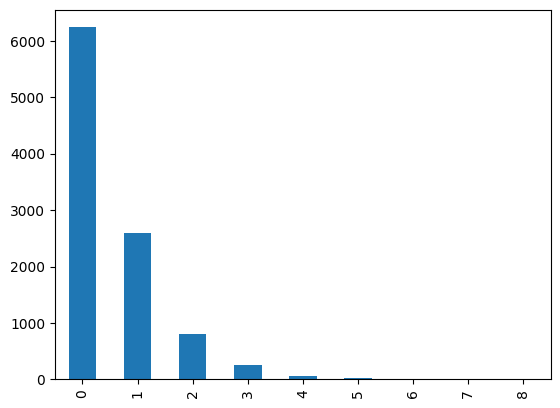

In [89]:
vc = success_recs_count.value_counts()
vc.plot.bar();
succes_proportion = round(1 - vc[0]/len(success_recs_count),4)
print(succes_proportion, "- доля совпадения хотя бы одной рекомендации\
из всех в покупках клиента")

А какого среднее отношение рекомендованных товаров к купленным, если рекомендация всё таки подошла?

In [90]:
succes_count_proportion = round(count_division[count_division != 0].mean(),4)
succes_count_proportion

0.3751

37% Это чуть хуже, чем неперсонализированные рекомендации

Выведем расределение позиции в топе у рекомендаций

35.0 - медиана
40.5747 - среднее


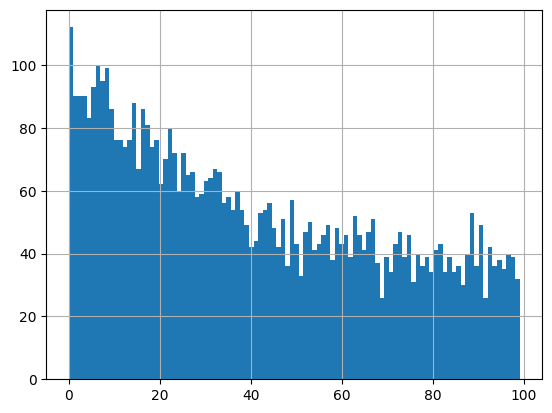

In [91]:
rank_distribution.hist(bins=100);

median = round(rank_distribution.median(),4)
mean = round(rank_distribution.mean(),4)
print(median, "- медиана")
print(mean, "- среднее")

Медиана открывает вторую треть, распределение смещено к первым рекомендациям, модель работает в соответствии с логикой рекомендаций. Хочется отметить, что ушли огромные провалы, что даёт вес гипотезе о категориях покупательных паттернов, где есть покупка популярных товаров и всех остальных. Две модели можно совместить, чтобы получить лучший результат т.к. распределение рейтинга рекомендаций у них не совпадает и не смотря на то, что неперсонализированные рекомендации оказались сильнее, есть места в распределении, где коллаборативная модель показывает лучшие результаты.

А какого общее соотношение удачно рекомендованных товаров ко всем покупкам?

In [92]:
all_succes_products_proportion = success_recs_count.sum() / y_test.apply(len).sum()
all_succes_products_proportion

0.14530618753986818

In [93]:
# save model results
models_results["my_collaborative"] = {
    "succes_proportion" : succes_proportion,
    "succes_count_proportion" : succes_count_proportion,
    "median" : median,
    "mean" : mean,
    "all_succes_products_proportion" : all_succes_products_proportion,
    "rank_distribution" : rank_distribution
}

# Word to Vector подходы

## FastText по названиям товаров в корзине

К каждому товару в корзине выводится ближайшая рекомендация по его названию. Причем количество рекомендаций одному товару зависит от того сколько товаров лежит в корзине. Нужно набрать 100 рекомендаций. Если их 50, то рекомендаций 50, если их 20, то рекомендаций 80.

В предобработке первым делом нужно удалить цифры и то, что идёт сразу после них. После чего стоит убрать цифры и преставки объема, длинны, веса. 

Лемматизация не имеет большого смысла, поскольку FastText подход подразумевает генерацию векторов из слов по буквам и n-граммам. 

In [94]:
## preprocessing strings
model_str = product_df.name
model_str = model_str.apply(simple_preprocess).apply(lambda x: " ".join(x))
model_str = model_str.apply(lambda x: x+ " ")

for _ in range(10):
    for string in ["см", "мм", "л", "мл", "гр", "мг", "мкг"]:
        model_str = model_str.str.replace(f" {string} ", " ", regex=True)    
        
model_str = model_str.str.strip()

In [95]:
model_str.to_csv("model_str.csv",index=False) # save strings as file for model

In [96]:
# train model
model_product = fasttext.train_unsupervised("model_str.csv", dim=50)

In [97]:
model_product.get_nearest_neighbors("витамин") # test model inside its dict 

[(0.9780542850494385, 'вит'),
 (0.967735230922699, 'витамины'),
 (0.9587873816490173, 'витамином'),
 (0.9572257995605469, 'витаминно'),
 (0.9484769701957703, 'витаминами'),
 (0.9446534514427185, 'витаон'),
 (0.941455066204071, 'глюкозамин'),
 (0.9405422806739807, 'мультивитамин'),
 (0.9373069405555725, 'глюкозамином'),
 (0.9204941987991333, 'цианокобаламин')]

In [98]:
# get array for each product name
product_array = []
for product in product_df.index:
        product_array.append(model_product[model_str.loc[product]])

In [99]:
# fit NearestNeighbors model
neigh_product = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(
            product_array)

In [100]:
train_names = transform_array(model_str, X_train)

In [101]:
train_names_test = transform_array(model_str, X_test)

In [102]:
%%time
# generate recomendations
recomendations = []
for lst in train_names_test:
    recs_per_item = math.ceil(100 / len(lst))
    recs = []
    for name in lst:
        neighbours = neigh_product.kneighbors([model_product[name]],
                                      recs_per_item, return_distance=False)
        recs += list(model_str.iloc[neighbours[0]].index)
    recomendations.append(recs[:100])

CPU times: total: 3min 18s
Wall time: 3min 19s


### Результаты

In [103]:
validation, success_recs_count, rank_distribution, count_division \
    = get_validation(recomendations, y_test)

Как часто рекомендации совпадают с покупками?

0.1649 - доля совпадения хотя бы одной рекомендациииз всех в покупках клиента


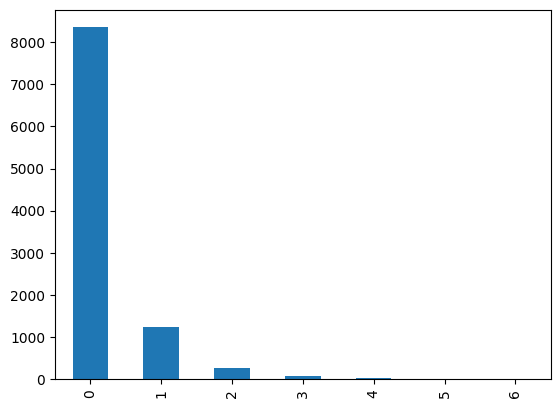

In [104]:
vc = success_recs_count.value_counts()
vc.plot.bar();
succes_proportion = round(1 - vc[0]/len(success_recs_count),4)
print(succes_proportion, "- доля совпадения хотя бы одной рекомендации\
из всех в покупках клиента")

Это значительно хуже чем рекомендовать самые популярные товары. То есть рекомендовать лекарства по похожему названию не самая хорошая идея:)

А какого среднее отношение рекомендованных товаров к купленным, если рекомендация всё таки подошла?

In [105]:
succes_count_proportion = round(count_division[count_division != 0].mean(),4)
succes_count_proportion

0.3091

почти 32%. Не самый плохой результат не учитывая того, что самые частые покупки в выборке - 1 товар.

Выведем расределение позиции в топе у рекомендаций

47.0 - медиана
46.9697 - среднее


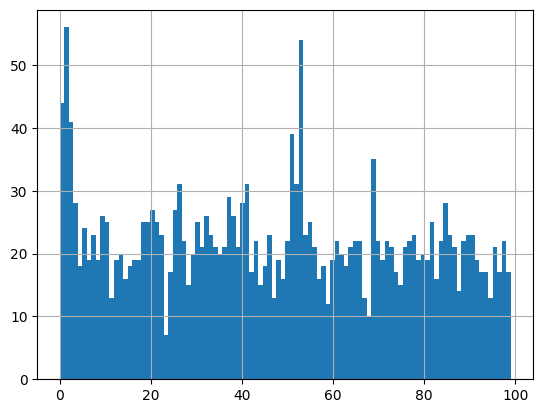

In [106]:
rank_distribution.hist(bins=100);

median = round(rank_distribution.median(),4)
mean = round(rank_distribution.mean(),4)
print(median, "- медиана")
print(mean, "- среднее")

Интересно! Среди первых рекомендаций - самые частые совпадения, но в остальном распределение плюс минус стационарно. То есть аналог(или просто похожее название) лекарства покупают после приобретения "оригинала". Во всяком случае можно наблюдать спрос на новые товары в узкой категории среди покупателей, но он небольшой и угасает в пределах 4 покупок.

А какого общее соотношение удачно рекомендованных товаров ко всем покупкам?

In [107]:
all_succes_products_proportion = success_recs_count.sum() / y_test.apply(len).sum()
all_succes_products_proportion

0.05871252392090155

Не удивительно

In [108]:
# save model results
models_results["w2v_products"] = {
    "succes_proportion" : succes_proportion,
    "succes_count_proportion" : succes_count_proportion,
    "median" : median,
    "mean" : mean,
    "all_succes_products_proportion" : all_succes_products_proportion,
    "rank_distribution" : rank_distribution
}

## Word2Vec по чековым последовательностям

Все тоже самое, что в предсказании по названию, но только обучение проходит не на отдельном назывании а на всём тренировочном чеке.

In [109]:
w2v_cheks = []        # train
for i in train_names:
    w2v_cheks.append(" ".join(i))
    
    
w2v_cheks_test = []        # test
for i in train_names_test:
    w2v_cheks_test.append(" ".join(i))

In [110]:
pd.Series(w2v_cheks).to_csv("checks_names.csv",index=False) # save strings as file

In [111]:
%%time
model_checks = fasttext.train_unsupervised("checks_names.csv", dim=50)

CPU times: total: 1h 17min 22s
Wall time: 7min 13s


In [112]:
%%time
w2v_cheks_arrays = []      # train
for string in w2v_cheks:
    w2v_cheks_arrays.append(model_checks[string])
    
w2v_cheks_test_arrays = [] # test
for string in w2v_cheks_test:
    w2v_cheks_test_arrays.append(model_checks[string])

CPU times: total: 2min 45s
Wall time: 2min 45s


In [113]:
%%time
neigh_checks = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(
            w2v_cheks_arrays)

CPU times: total: 35.9 s
Wall time: 35.9 s


In [114]:
%%time
results = Parallel(n_jobs=-1)(delayed(get_w2v_check_recs)(x)
                                  for x in chunker(list(range(10000))))
recomendations = []
for lst in results: recomendations += lst

CPU times: total: 35.3 s
Wall time: 11min 52s


### Результаты

In [115]:
validation, success_recs_count, rank_distribution, count_division \
    = get_validation(recomendations, y_test)

Как часто рекомендации совпадают с покупками?

0.3292 - доля совпадения хотя бы одной рекомендациииз всех в покупках клиента


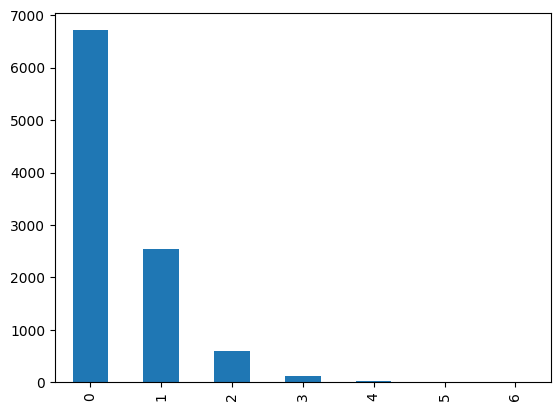

In [116]:
vc = success_recs_count.value_counts()
vc.plot.bar();
succes_proportion = round(1 - vc[0]/len(success_recs_count),4)
print(succes_proportion, "- доля совпадения хотя бы одной рекомендации\
из всех в покупках клиента")

Что гораздо лучше, чем у рекомендаций по названию. Ура коллаборативности!

А какого среднее отношение рекомендованных товаров к купленным, если рекомендация всё таки подошла?

In [117]:
succes_count_proportion = round(count_division[count_division != 0].mean(),4)
succes_count_proportion

0.3931

Модель показала лучшую долю рекомендаций к купленным товарам

Выведем расределение позиции в топе у рекомендаций

41.0 - медиана
43.448 - среднее


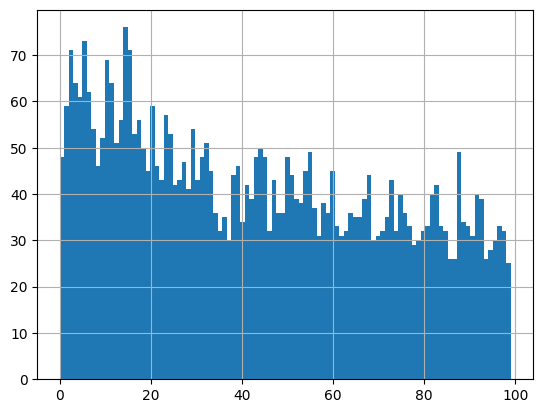

In [118]:
rank_distribution.hist(bins=100);

median = round(rank_distribution.median(),4)
mean = round(rank_distribution.mean(),4)
print(median, "- медиана")
print(mean, "- среднее")

Распределение имеет тенденцию сгущаться к началу рекомендаций, что хорошо, но результат по сравнению с предыдущими моделями посредственный. Интересно, что самые частые совпадения происходят со 2 по 9 место в рейтинге.

А какого общее соотношение удачно рекомендованных товаров ко всем покупкам?

In [119]:
all_succes_products_proportion = success_recs_count.sum() / y_test.apply(len).sum()
all_succes_products_proportion

0.11306612800340209

In [120]:
# save model results
models_results["w2v_checks"] = {
    "succes_proportion" : succes_proportion,
    "succes_count_proportion" : succes_count_proportion,
    "median" : median,
    "mean" : mean,
    "all_succes_products_proportion" : all_succes_products_proportion,
    "rank_distribution" : rank_distribution
}

# Двухстадийная рекомендательная система с кандидатогенерацией и ранжированием разной природы
- **Кандидатогенерация** по w2v ближайшим соседям из чековых последовательностей
- **Ранжирование** по коллаборативному алгоритму

In [121]:
%%time
results = Parallel(n_jobs=-1)(delayed(get_2stage_w2v_collab_recs)(x)
                                  for x in chunker(list(range(10000))))
recomendations = []
for lst in results: recomendations += lst

CPU times: total: 4.89 s
Wall time: 17min 22s


## Результаты

In [122]:
validation, success_recs_count, rank_distribution, count_division \
    = get_validation(recomendations,y_test)


Как часто рекомендации совпадают с покупками?

0.4915 - доля совпадения хотя бы одной рекомендациииз всех в покупках клиента


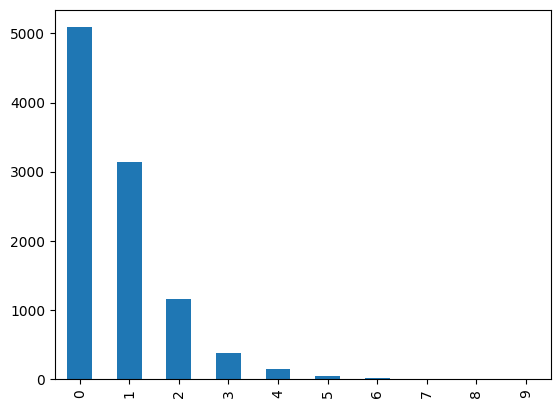

In [123]:
vc = success_recs_count.value_counts()
vc.plot.bar();
succes_proportion = round(1 - vc[0]/len(success_recs_count),4)
print(succes_proportion, "- доля совпадения хотя бы одной рекомендации\
из всех в покупках клиента")

Считай половина всех покупок содержит хотя-бы одну рекомендацию

А какого среднее отношение рекомендованных товаров к купленным, если рекомендация всё таки подошла?

In [124]:
succes_count_proportion = round(count_division[count_division != 0].mean(),4)
succes_count_proportion

0.4394

И хорошее соотношение рекомендаций внутри покупок

Выведем расределение позиции в топе у рекомендаций

32.0 - медиана
37.6877 - среднее


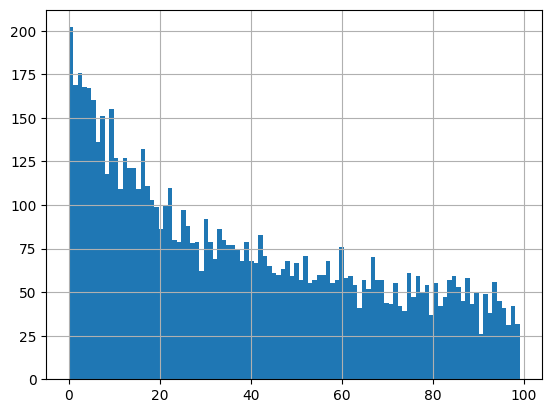

In [125]:
rank_distribution.hist(bins=100);

median = round(rank_distribution.median(),4)
mean = round(rank_distribution.mean(),4)
print(median, "- медиана")
print(mean, "- среднее")

Лучшее распределение - в верху топа гуще всего, нет большого разброса и медиана отличная

А какого общее соотношение удачно рекомендованных товаров ко всем покупкам?

In [126]:
all_succes_products_proportion = success_recs_count.sum() / y_test.apply(len).sum()
all_succes_products_proportion

0.20343397831171592

Юху! 2/10 тысячи всех покупок совпали с рекомендациями

In [127]:
# save model results
models_results["2stage_w2v_collab"] = {
    "succes_proportion" : succes_proportion,
    "succes_count_proportion" : succes_count_proportion,
    "median" : median,
    "mean" : mean,
    "all_succes_products_proportion" : all_succes_products_proportion,
    "rank_distribution" : rank_distribution
}

# Сравнение моделей

Напомню, количество рекомендаций  - 100, тестовая выборка - 10000 клиентов и их уникальные последовательные покупки.
- succes_proportion - отношение покупкам с хотя-бы одной совпавшей рекомендацией ко всем покупкам
- succes_count_proportion - отношение рекомендованных товаров к общему количеству купленных товаров
- all_succes_products_proportion - отношение рекомендованных товаров к их общему количеству в покупках

График показывает боксплоты распределения позиции в рекомендациях(чем ниже, тем лучше) 

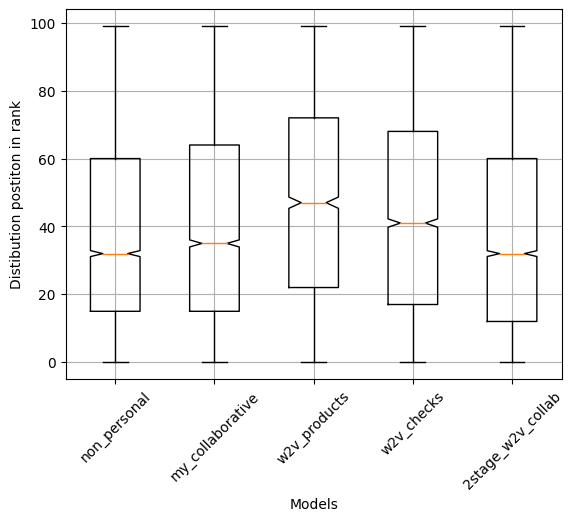

,non_personal,my_collaborative,w2v_products,w2v_checks,2stage_w2v_collab
succes_proportion,0.4216,0.3762,0.1649,0.3292,0.4915
succes_count_proportion,0.3873,0.3751,0.3091,0.3931,0.4394
median,32.0,35.0,47.0,41.0,32.0
mean,38.6042,40.5747,46.9697,43.448,37.6877
all_succes_products_proportion,0.167898,0.145306,0.058713,0.113066,0.203434


In [128]:
result_df = pd.DataFrame(models_results)
rank_distributions = result_df.loc["rank_distribution"].apply(lambda x: list(x))

results = list(rank_distributions)

fig, ax = plt.subplots()
bp = ax.boxplot(results, labels=rank_distributions.index, sym='k+',
                notch=True)

ax.set_xlabel('Models')
ax.set_ylabel('Distibution postiton in rank')
plt.xticks(rotation = 45)
plt.grid()
plt.show()

result_df.drop(["rank_distribution"], axis="rows")

На удивление подбор просто популярных товаров оказался эффективнее подбора по названию, коллаборативной модели и w2v коллаборативной модели. Но коллаборативная w2v модель обогнала его по количеству рекомендованных товаров среди покупок с хотя бы одним рекомендованным товаром.

Результат неперсонализированных рекомендаций можно с хорошим отрывом обойти совмещая коллаборативные методы.

Важно сказать что в точном смысле этого слова рекомендации представляли из себя прогнозы того, какой новый товар купит покупатель по предыдущим уникальным покупкам. И сам факт рекомендации влияет на покупки клиента, так что к мощности таким образом проверенных рекомендаций стоит относиться с оговорокй. Для действительно хорошо интерпретируемой валидации нужно проводить A/B тесты на реальных покупках. 

# Идеи и примечания
Содержит точки роста и замечания к бизнес логике

- Важно, чтобы во время покупки клиенту не рекомендовались товары, которых нет в текущей аптеке. 
- Добавить предложение маленького пакета если товаров больше одного
- В бизнес логику рекомендаций можно добавить паттерн, по которому клиенту будет рекомендоваться товар, который он часто приобретает, но только по истченению курса приёма с запасом в одну-две недели
- Коллаборативные и неперсонализированные рекомендации имеют разное распределение рейтинга совпавших товаров, точно есть места, где один алгоритм справляется лучше другого и наоборот. Это значит, что правильное объединение их результатов даст прирост к результативности модели
- Если в коллаборативном алгоритме не подберать индексы слишком больших векторов сделанных покупок к текущему и меньшему вектору до этапа сложения векторов для нахождения популярных товаров. То в теории можно получить более точные рекомендации
- Можно валидировать товары по описанию с помощью близости вектора рекомендованного товара к вектору товара, который клиент аптеки действительно купил. Это удобно на случай, если хочется нивелировать эффект аналогов препаратов.
- Можно научить классификатор определять, рекомендации скорее подойдут или нет, так можно увеличить метрику удачных рекомендаций и клиенты будут лояльнее относиться к рекомендациям.
- Подход в котором по вектору предсказывается вектор, а не конкретное число